## Елисеев Е.В.
## Нейросеть бинарной классификации сонливости водителей
Данные взяты с <a href="https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd">kaggle<a>

In [1]:
# Бинарная кросс-энтропия и сигмоида
import os
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import sys
import random
import matplotlib.pyplot as plt


sys.executable
DROWSY_IMG_PATH = "data/Driver Drowsiness Dataset (DDD)/Drowsy/"
NON_DROWSY_IMG_PATH = "data/Driver Drowsiness Dataset (DDD)/Non Drowsy/"
img_size = (190, 190)
max_images = 6000


def read_imgs(path, max_images=None):
    image_files = [file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))]
    random.shuffle(image_files)
    images = []
    if max_images:
        image_files = image_files[:max_images]
        
    for img_name in tqdm(image_files):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        if img is not None:
            images.append(img)
    return images


# Чтение изображений
drowsy_files = np.array(read_imgs(DROWSY_IMG_PATH, max_images=int(max_images / 2)))
non_drowsy_files = np.array(read_imgs(NON_DROWSY_IMG_PATH, max_images=int(max_images / 2)))

len(drowsy_files), len(non_drowsy_files)

2023-12-21 21:51:07.568781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 21:51:07.568818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 21:51:07.569420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 21:51:07.573383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 21:51:08.080797: W tensorflow/compiler/tf2

(3000, 3000)

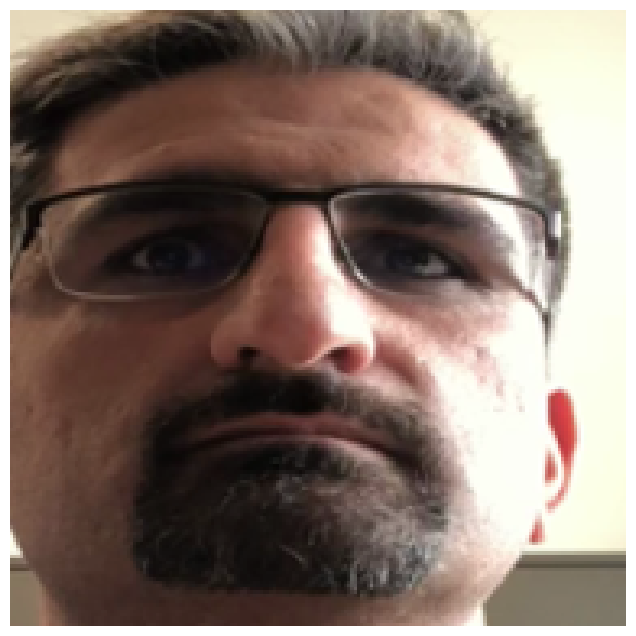

In [ ]:
# Пример изображения
selected_image = non_drowsy_files[99]
converted_image = cv2.cvtColor(selected_image, cv2.COLOR_BGR2RGB)

figure = plt.figure(figsize=(8, 8))
plt.imshow(converted_image)
plt.axis('off')
plt.show()

In [ ]:
# Разделение изображений на обучающую, валидационную и тестовую выборки
train_drowsy, val_test_drowsy  = train_test_split(drowsy_files, test_size=0.3, random_state=42)
val_drowsy, test_drowsy = train_test_split(val_test_drowsy , test_size=0.5, random_state=42)

train_non_drowsy, val_test_non_drowsy  = train_test_split(non_drowsy_files, test_size=0.3, random_state=42)
val_non_drowsy, test_non_drowsy = train_test_split(val_test_non_drowsy , test_size=0.5, random_state=42)


# Получение размера изображений в памяти в мб
def get_size(var):
    return round(sys.getsizeof(var) / 1_000_000, 2)


print(f"Количество данных для обучения: {len(train_drowsy) + len(train_non_drowsy)}, {get_size(train_drowsy) + get_size(train_non_drowsy)} мб")
print(f"Количество данных для валидации: {len(val_drowsy) + len(val_non_drowsy)}, {get_size(val_drowsy) + get_size(val_non_drowsy)} мб")
print(f"Количество данных для тестирования: {len(test_drowsy) + len(test_non_drowsy)}, {get_size(test_drowsy) + get_size(test_non_drowsy)} мб")

Количество данных для обучения: 4200, 3638.88 мб
Количество данных для валидации: 900, 779.76 мб
Количество данных для тестирования: 900, 779.76 мб


In [ ]:
from tensorflow.keras.optimizers import RMSprop


# Очистка памяти от ненужных переменных
del drowsy_files
del non_drowsy_files

# Архитектура модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'), 
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

batch_size = 8
epochs = 50

model.compile(optimizer=RMSprop(), loss=BinaryCrossentropy(), metrics=[Accuracy()])

2023-12-21 18:00:12.951703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 18:00:13.254548: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 18:00:13.254589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 18:00:13.256574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-21 18:00:13.256619: I external/local_xla/xla/stream_executor

In [ ]:
model.fit(np.concatenate((train_drowsy, train_non_drowsy)), 
          np.array([1] * len(train_drowsy) + [0] * len(train_non_drowsy)),
          batch_size=batch_size, epochs=epochs,
          validation_data=(np.concatenate((val_drowsy, val_non_drowsy)),
                           np.array([1] * len(val_drowsy) + [0] * len(val_non_drowsy))))

# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(np.concatenate((test_drowsy, test_non_drowsy)), 
                                          np.array([1] * len(test_drowsy) + [0] * len(test_non_drowsy)))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2023-12-21 18:00:55.267094: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1819440000 exceeds 10% of free system memory.
2023-12-21 18:00:58.755298: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1819440000 exceeds 10% of free system memory.


Epoch 1/50


2023-12-21 18:01:06.960462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-21 18:01:07.234385: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-21 18:01:08.013551: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-21 18:01:08.687655: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f311eef4930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 18:01:08.687684: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-21 18:01:08.746343: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703163668.864316    1168 device_compiler.

525/525 [==============================] - 18s 14ms/step - loss: 0.5709 - accuracy: 0.0029 - val_loss: 0.1275 - val_accuracy: 0.0300
Epoch 2/50
525/525 [==============================] - 5s 10ms/step - loss: 0.1590 - accuracy: 0.0643 - val_loss: 0.0286 - val_accuracy: 0.0744
Epoch 3/50
525/525 [==============================] - 5s 10ms/step - loss: 0.1091 - accuracy: 0.1879 - val_loss: 0.0184 - val_accuracy: 0.2367
Epoch 4/50
525/525 [==============================] - 5s 9ms/step - loss: 0.1036 - accuracy: 0.3231 - val_loss: 0.0205 - val_accuracy: 0.3178
Epoch 5/50
525/525 [==============================] - 5s 9ms/step - loss: 0.0810 - accuracy: 0.3857 - val_loss: 0.0230 - val_accuracy: 0.3722
Epoch 6/50
525/525 [==============================] - 5s 9ms/step - loss: 0.0370 - accuracy: 0.4110 - val_loss: 0.0101 - val_accuracy: 0.4689
Epoch 7/50
525/525 [==============================] - 5s 9ms/step - loss: 0.0526 - accuracy: 0.4607 - val_loss: 0.0220 - val_accuracy: 0.4700
Epoch 8/50
52

29/29 [==============================] - 4s 9ms/step


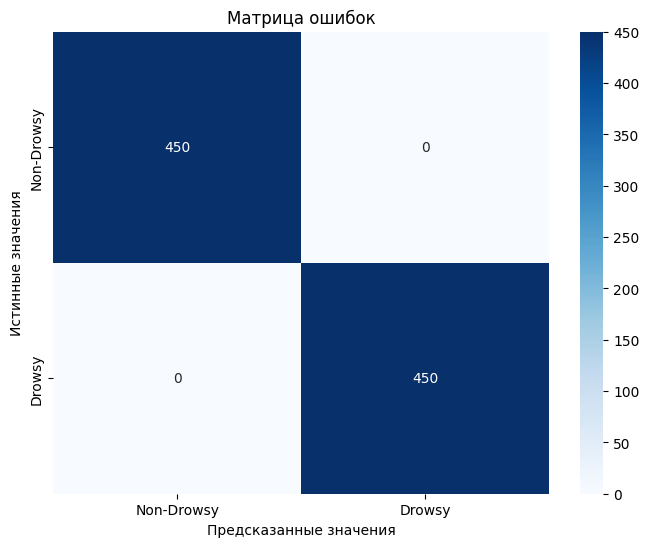

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Получение предсказаний модели для тестовых данных
predictions = model.predict(np.concatenate((test_drowsy, test_non_drowsy)))

# Преобразование вероятностей в метки классов (0 или 1) с использованием порога 0.5
predicted_classes = (predictions > 0.5).astype(int)

# Создание матрицы ошибок
labels = np.array([1] * len(test_drowsy) + [0] * len(test_non_drowsy))
conf_matrix = confusion_matrix(labels, predicted_classes)

# Создание тепловой карты для визуализации матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Drowsy', 'Drowsy'], 
            yticklabels=['Non-Drowsy', 'Drowsy'])

plt.title('Матрица ошибок')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.show()

In [ ]:
model.save('model/my_model')

1/1 [==============================] - 0s 11ms/step


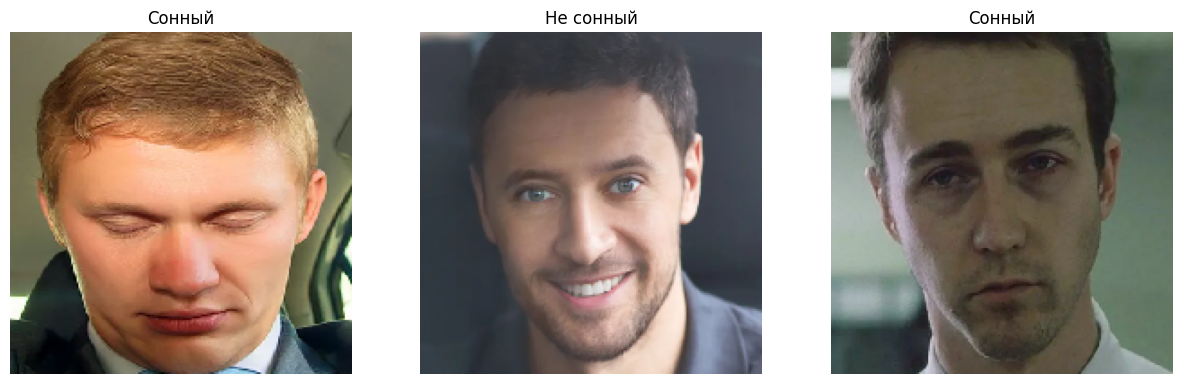

In [ ]:
# Проверка нейронной сети на данных не из датасета 
def predict(model, data_path):
    image_files = [file for file in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, file))]
    images = []
    predictions = []
    
    for img_name in image_files:
        img = image.load_img(os.path.join(data_path, img_name), target_size=img_size)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.0  # Нормализация
        
        images.append(img)
        prediction = model.predict(img)
        predictions.append(prediction[0])

    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))

    for i, (img, prediction) in enumerate(zip(images, predictions)):
        axes[i].imshow(img[0])
        if prediction >= 0.5:
            axes[i].set_title("Сонный")
        else:
            axes[i].set_title("Не сонный")
        axes[i].axis('off')

    plt.show()
            

# Путь к картинкам
test_data_path = f"data/test"

# Смотрим все тестовые снимки
predict(model, test_data_path)